In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import os
os.getcwd()            # shows where Python is looking by default        # list the files in that directory
os.chdir("/work")

When working with data from multiple years 

In [3]:
from PadSquare import PadSquare

In [4]:
coco_roots = ['/work/2021_annot/images',
              '/work/2022_annot/images',
              '/work/2023_annot/images',
              '/work/2024_annot/images']

coco_annFiles = ['/work/2021_annot/2021_annotations.json',
                 '/work/2022_annot/2022_annotations.json',
                 '/work/2023_annot/2023_annotations_corrected.json',
                 '/work/2024_annot/2024_annotations.json']
bad_samples_roots = ['/work/2023_annot/bad_samples/',
                    '/work/2024_annot/bad_samples/',
                    '/work/2021_annot/bad_samples/',
                    '/work/2022_annot/bad_samples/']    


standard_transform = transforms.v2.Compose([
    PadSquare(0), 
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
# First wrap the dataset with the new taggable key
full_dataset = datasets.CocoDetection(root=coco_roots[0], annFile=coco_annFiles[0], transforms=standard_transform)
full_dataset = datasets.wrap_dataset_for_transforms_v2(full_dataset, target_keys=("labels", "masks"))
classifier_dataset = datasets.ImageFolder(root=bad_samples_roots[0], transform=standard_transform)


for coco_root, coco_annFile, bad_sample_root in zip(coco_roots[1:], coco_annFiles[1:], bad_samples_roots[1:]):
    seasonal_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
    seasonal_dataset = datasets.wrap_dataset_for_transforms_v2(seasonal_dataset, target_keys=("labels", "masks"))
    full_dataset = torch.utils.data.ConcatDataset([full_dataset, seasonal_dataset])
    seasonal_classifier_dataset = datasets.ImageFolder(root=bad_sample_root, transform=standard_transform) 
    classifier_dataset = torch.utils.data.ConcatDataset([classifier_dataset, seasonal_classifier_dataset])
    indices = torch.randperm(len(full_dataset)).tolist()
    full_dataset = torch.utils.data.Subset(full_dataset, indices)
# Add labels to the classifier_dataset
classifier_dataset = [(img, 0) for img, _ in classifier_dataset]
#sort the taggable images from the annotation dataset
for i in tqdm(range(len(full_dataset))):
    labels = full_dataset[i][1]["labels"]
    # print(labels)
    taggable = (len(torch.unique(labels)) == 3)
    # print(f"Taggable: {taggable}")
    if taggable:
        classifier_dataset.append((full_dataset[i][0], 1))
    else:
        classifier_dataset.append((full_dataset[i][0], 0))


train_size = int(0.8 * len(classifier_dataset))
test_size = int(0.2 * len(classifier_dataset))
test_size += len(classifier_dataset) - (train_size + test_size)
print(f"Train size: {train_size}, Test size: {test_size}")
torch.manual_seed = 69
classifier_dataset_train, classifier_dataset_test = torch.utils.data.random_split(classifier_dataset, [train_size, test_size])
# Now we can use the classifier_dataset for training
del full_dataset

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


100%|████████████████████████████████████████████████████████████████████████████████████████| 412/412 [01:08<00:00,  6.01it/s]

Train size: 523, Test size: 131


Next, I will obtain a mix of 74 bad photos and put them in a sub folder, creating a new classifier dataset. 


In [6]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn as nn
preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
model = smp.Unet('resnet34', encoder_weights='imagenet', in_channels=3, classes=4, activation=None)
model.load_state_dict(torch.load('/work/best_model.pth', map_location=device,weights_only=True))
model = model.to(device)

In [7]:
# TODO: bring in the CLIP example to show improvements over it
from sklearn.linear_model import LogisticRegression
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.model_selection import GridSearchCV
def get_UNET_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=1)):
            img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in images])
            img = img.permute(0, 3, 1, 2).float()
            result = model.encoder(img.to(device))
            features = result[-1]
            # Get the batch size and space size dynamically
            batch_size, space_size, _, _ = features.shape
            #tried max pooling instead of average pooling, it didn't work
            flattened_tensor = features.view(batch_size, space_size, -1).mean(dim=-1)
            all_features.append(flattened_tensor.cpu())
            all_labels.append(labels)

    return torch.cat(all_features).numpy(), torch.cat(all_labels).numpy()

train_x, train_y = get_UNET_features(classifier_dataset_train)
test_x, test_y = get_UNET_features(classifier_dataset_test)

# Define the parameter grid
param_grid = {'C': np.logspace(-4, 4, 20)}

# Initialize the logistic regression model
logistic = LogisticRegression(random_state=0, max_iter=10000)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(logistic, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(train_x, train_y)

# Get the best parameter and the best score
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best cross-validation accuracy: {best_score:.3f}")

# Evaluate using the best logistic regression classifier
best_classifier = grid_search.best_estimator_
predictions = best_classifier.predict(test_x)
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")
results_dict = {"CNN_logistic": accuracy}
# Save the best classifier


100%|███████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 227.12it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best C: 4.281332398719396
Best cross-validation accuracy: 0.925
Test accuracy = 92.366


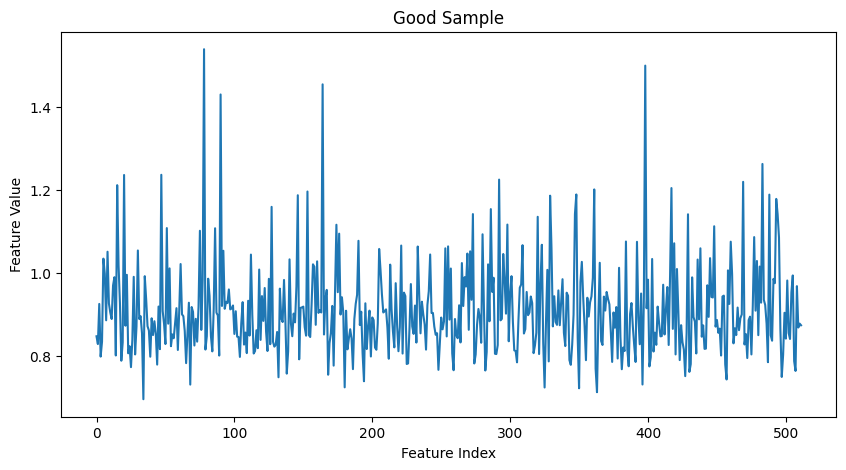

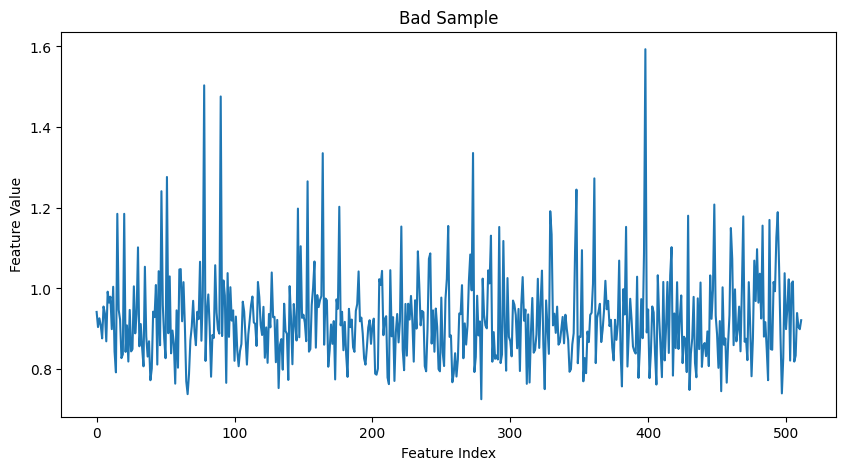

In [8]:
# print(train_x[1], train_y[2]) 

plt.figure(figsize=(10, 5))
plt.plot(train_x[0])
plt.title('Good Sample')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_x[2])
plt.title('Bad Sample')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

In [10]:
# # Find the indices of incorrect predictions
# incorrect_indices = np.where(test_y != predictions)[0]

# # Plot the incorrect predictions
# fig, axes = plt.subplots(len(incorrect_indices), 1, figsize=(10, len(incorrect_indices) * 5))

# for idx, incorrect_idx in enumerate(incorrect_indices):
#     image, label = classifier_dataset_test[incorrect_idx]
#     axes[idx].imshow(image.permute(1, 2, 0))
#     axes[idx].set_title(f"True label: {test_y[incorrect_idx]}, Predicted: {predictions[incorrect_idx]}")
#     axes[idx].axis('off')

# plt.tight_layout()
# plt.show()

### New Classifiers 
Starting with SVM

In [9]:
# We still have train_x and train_y, so we can use them to train a new model
from sklearn import svm
svm_model = svm.SVC(kernel='poly', random_state=0, max_iter=10000)
svm_grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=1, n_jobs=-1)
svm_grid_search.fit(train_x, train_y)
# Get the best parameter and the best score
svm_best_C = svm_grid_search.best_params_['C']
svm_best_score = svm_grid_search.best_score_
print(f"SVM Best C: {svm_best_C}")
print(f"SVM Best cross-validation accuracy: {svm_best_score:.3f}")
# Evaluate using the best svm classifier
best_svm = svm_grid_search.best_estimator_
predictions = best_svm.predict(test_x)
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")
results_dict["CNN_SVM"] = accuracy

Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVM Best C: 0.00026366508987303583
SVM Best cross-validation accuracy: 0.927
Test accuracy = 90.840


In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, verbose=1, n_jobs=-1)
knn_grid_search.fit(train_x, train_y)
# Get the best parameter and the best score
knn_best_C = knn_grid_search.best_params_      
knn_best_score = knn_grid_search.best_score_
print(f"KNN Best C: {knn_best_C}")
print(f"KNN Best cross-validation accuracy: {knn_best_score:.3f}")
# Evaluate using the best knn classifier
best_knn = knn_grid_search.best_estimator_
predictions = best_knn.predict(test_x)
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")
results_dict["CNN_KNN"] = accuracy


Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN Best C: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
KNN Best cross-validation accuracy: 0.922
Test accuracy = 89.313


In [11]:
#simple NN 
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size=512, hidden_size=1024):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return self.sigmoid(x)
        # return x

model_nn = SimpleNN().to(device)
print(model_nn)

SimpleNN(
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [12]:
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim

# Convert train_x and train_y to tensors
train_tensor_x = torch.from_numpy(train_x).float()  # shape should match (N, 512)
train_tensor_y = torch.from_numpy(train_y).float().unsqueeze(1)  # shape (N, 1) for BCELoss

# Create dataset and loader
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Set up loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=1e-4)
num_epochs = 2000

# Training loop
model_nn.train()
pocket_model = model_nn
pocket_loss = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model_nn(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    epoch_loss = running_loss / len(train_dataset)
    if epoch_loss < pocket_loss:
        pocket_model = model_nn
        pocket_loss = epoch_loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

/opt/sam2_env/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 1/2000, Loss: 0.6830
Epoch 2/2000, Loss: 0.6813
Epoch 3/2000, Loss: 0.6806
Epoch 4/2000, Loss: 0.6758
Epoch 5/2000, Loss: 0.6797
Epoch 6/2000, Loss: 0.6762
Epoch 7/2000, Loss: 0.6751
Epoch 8/2000, Loss: 0.6716
Epoch 9/2000, Loss: 0.6804
Epoch 10/2000, Loss: 0.6688
Epoch 11/2000, Loss: 0.6718
Epoch 12/2000, Loss: 0.6685
Epoch 13/2000, Loss: 0.6694
Epoch 14/2000, Loss: 0.6685
Epoch 15/2000, Loss: 0.6637
Epoch 16/2000, Loss: 0.6683
Epoch 17/2000, Loss: 0.6782
Epoch 18/2000, Loss: 0.6593
Epoch 19/2000, Loss: 0.6711
Epoch 20/2000, Loss: 0.6628
Epoch 21/2000, Loss: 0.6567
Epoch 22/2000, Loss: 0.6530
Epoch 23/2000, Loss: 0.6600
Epoch 24/2000, Loss: 0.6527
Epoch 25/2000, Loss: 0.6475
Epoch 26/2000, Loss: 0.6496
Epoch 27/2000, Loss: 0.6449
Epoch 28/2000, Loss: 0.6565
Epoch 29/2000, Loss: 0.6374
Epoch 30/2000, Loss: 0.6361
Epoch 31/2000, Loss: 0.6610
Epoch 32/2000, Loss: 0.6438
Epoch 33/2000, Loss: 0.6417
Epoch 34/2000, Loss: 0.6376
Epoch 35/2000, Loss: 0.6283
Epoch 36/2000, Loss: 0.6284
E

In [13]:
import copy
pocket_model = copy.deepcopy(model_nn)
model_nn.eval()
predictions = model_nn(torch.from_numpy(test_x).float().to(device))
# predictions = torch.sigmoid(predictions)
predictions = predictions.cpu().detach().numpy()
predictions = np.round(predictions).flatten()
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")
results_dict["CNN_NN"] = accuracy

Test accuracy = 93.130


In [14]:
# _MODELS = {
#     "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
#     "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
#     "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
#     "RN50x16": "https://openaipublic.azureedge.net/clip/models/52378b407f34354e150460fe41077663dd5b39c54cd0bfd2b27167a4a06ec9aa/RN50x16.pt",
#     "RN50x64": "https://openaipublic.azureedge.net/clip/models/be1cfb55d75a9666199fb2206c106743da0f6468c9d327f3e0d0a543a9919d9c/RN50x64.pt",
#     "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
#     "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
#     "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
#     "ViT-L/14@336px": "https://openaipublic.azureedge.net/clip/models/3035c92b350959924f9f00213499208652fc7ea050643e8b385c2dac08641f02/ViT-L-14-336px.pt",
# }

from torch.utils.data import Dataset
class WrapperDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data  # List of (image, label) tuples
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

In [18]:
# Calculate the image features
import clip
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset

def get_clip_features(dataset):
    all_features = []
    all_labels = []
    print(f"Dataset size: {len(dataset)}")
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=4)):
            
            features = model.encode_image(images.to(device))
            # print(f"Batch {i}, features shape: {features.shape}, labels: {labels}")
    
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# print(f"Classifier dataset size: {len(classifier_dataset)}")
# Calculate the image features



# datasets are a list of tuples (image, label)
# transforms are not getting applied
# need to convert back to a dataset object. 
combined_transform = transforms.v2.Compose([transforms.v2.ToPILImage(), preprocess])
wrapped_train_dataset = WrapperDataset(classifier_dataset_train, transform=combined_transform)
wrapped_test_dataset = WrapperDataset(classifier_dataset_test, transform=combined_transform)


# classifier_dataset_train.transform = preprocess
# classifier_dataset_test.transform = preprocess
train_features, train_labels = get_clip_features(wrapped_train_dataset)
test_features, test_labels = get_clip_features(wrapped_test_dataset)

# # Perform logistic regression
# classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
# classifier.fit(train_features, train_labels)

# # Evaluate using the logistic regression classifier
# predictions = classifier.predict(test_features)
# accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
# print(f"Accuracy = {accuracy:.3f}")
# Define the parameter grid
param_grid = {'C': np.logspace(-4, 4, 20)}

# Initialize the logistic regression model
logistic = LogisticRegression(random_state=0, max_iter=10000)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(logistic, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(train_features, train_labels)

# Get the best parameter and the best score
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best cross-validation accuracy: {best_score:.3f}")

# Evaluate using the best logistic regression classifier
best_classifier = grid_search.best_estimator_
predictions = best_classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")
results_dict["CLIP_logistic"] = accuracy

100%|███████████████████████████████████████| 338M/338M [00:14<00:00, 25.0MiB/s]


Dataset size: 523


100%|███████████████████████████████████████████████████████████████████████| 131/131 [00:03<00:00, 33.30it/s]


Dataset size: 131


100%|█████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 91.41it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best C: 0.615848211066026
Best cross-validation accuracy: 0.935
Test accuracy = 90.840


In [19]:
# We still have train_x and train_y, so we can use them to train a new model
from sklearn import svm
svm_model = svm.SVC(kernel='poly', random_state=0, max_iter=10000)
svm_grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=1, n_jobs=-1)
svm_grid_search.fit(train_features, train_labels)
# Get the best parameter and the best score
svm_best_C = svm_grid_search.best_params_['C']
svm_best_score = svm_grid_search.best_score_
print(f"SVM Best C: {svm_best_C}")
print(f"SVM Best cross-validation accuracy: {svm_best_score:.3f}")
# Evaluate using the best svm classifier
best_svm = svm_grid_search.best_estimator_
predictions = best_svm.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")
results_dict["CLIP_SVM"] = accuracy

Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVM Best C: 11.288378916846883
SVM Best cross-validation accuracy: 0.943
Test accuracy = 93.893


In [20]:
import joblib
joblib.dump(svm_grid_search.best_estimator_, "best_svm.joblib")

['best_svm.joblib']

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, verbose=1, n_jobs=-1)
knn_grid_search.fit(train_features, train_labels)
# Get the best parameter and the best score
knn_best_C = knn_grid_search.best_params_      
knn_best_score = knn_grid_search.best_score_
print(f"KNN Best C: {knn_best_C}")
print(f"KNN Best cross-validation accuracy: {knn_best_score:.3f}")
# Evaluate using the best knn classifier
best_knn = knn_grid_search.best_estimator_
predictions = best_knn.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")
results_dict["CLIP_KNN"] = accuracy

Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN Best C: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
KNN Best cross-validation accuracy: 0.912
Test accuracy = 92.366


In [22]:
class ClipEmbeddingNN(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=1024, dropout_rate=0.3):
        super(ClipEmbeddingNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_dim, 1)
        self.output_activation = nn.Sigmoid()

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.output_activation(x)
        return x

# Usage Example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ClipEmbeddingNN(input_dim=512, hidden_dim=1024).to(device)
print(model)


ClipEmbeddingNN(
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=1024, out_features=1, bias=True)
  (output_activation): Sigmoid()
)


In [23]:
# Convert train_x and train_y to tensors
train_tensor_x = torch.from_numpy(train_x).float()
train_tensor_y = torch.from_numpy(train_y).float().unsqueeze(1)

# Create dataset and loader
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Set up loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 2000

# Training loop
model.train()
pocket_model = model
pocket_loss = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    epoch_loss = running_loss / len(train_dataset)
    if epoch_loss < pocket_loss:
        pocket_model = model
        pocket_loss = epoch_loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/2000, Loss: 0.7313
Epoch 2/2000, Loss: 0.7102
Epoch 3/2000, Loss: 0.7340
Epoch 4/2000, Loss: 0.6943
Epoch 5/2000, Loss: 0.6951
Epoch 6/2000, Loss: 0.7051
Epoch 7/2000, Loss: 0.6948
Epoch 8/2000, Loss: 0.6850
Epoch 9/2000, Loss: 0.6918
Epoch 10/2000, Loss: 0.6733
Epoch 11/2000, Loss: 0.6713
Epoch 12/2000, Loss: 0.6901
Epoch 13/2000, Loss: 0.6759
Epoch 14/2000, Loss: 0.6661
Epoch 15/2000, Loss: 0.6834
Epoch 16/2000, Loss: 0.6711
Epoch 17/2000, Loss: 0.6556
Epoch 18/2000, Loss: 0.6690
Epoch 19/2000, Loss: 0.6532
Epoch 20/2000, Loss: 0.6495
Epoch 21/2000, Loss: 0.6602
Epoch 22/2000, Loss: 0.6306
Epoch 23/2000, Loss: 0.6552
Epoch 24/2000, Loss: 0.6385
Epoch 25/2000, Loss: 0.6328
Epoch 26/2000, Loss: 0.6672
Epoch 27/2000, Loss: 0.6459
Epoch 28/2000, Loss: 0.6325
Epoch 29/2000, Loss: 0.6492
Epoch 30/2000, Loss: 0.6766
Epoch 31/2000, Loss: 0.6321
Epoch 32/2000, Loss: 0.6140
Epoch 33/2000, Loss: 0.6150
Epoch 34/2000, Loss: 0.6200
Epoch 35/2000, Loss: 0.6390
Epoch 36/2000, Loss: 0.6166
E

In [24]:
# Evaluation
model.eval()
predictions = model(torch.from_numpy(test_x).float().to(device))
predictions = predictions.cpu().detach().numpy()
predictions = np.round(predictions).flatten()
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")
results_dict["CLIP_NN"] = accuracy

Test accuracy = 89.313


In [25]:
print(results_dict) 

{'CNN_logistic': np.float64(92.36641221374046), 'CNN_SVM': np.float64(90.83969465648855), 'CNN_KNN': np.float64(89.31297709923665), 'CNN_NN': np.float64(93.12977099236642), 'CLIP_logistic': np.float64(90.83969465648855), 'CLIP_SVM': np.float64(93.89312977099237), 'CLIP_KNN': np.float64(92.36641221374046), 'CLIP_NN': np.float64(89.31297709923665)}


In [27]:
import pandas as pd
# Reorganize into a new format
organized_data = {}

for key, value in results_dict.items():
    model, classifier = key.split('_')
    if model not in organized_data:
        organized_data[model] = {}
    organized_data[model][classifier] = value

# Create a DataFrame
metrics_df = pd.DataFrame.from_dict(organized_data, orient='index')

# Optional: reorder the classifier columns
metrics_df = metrics_df[['logistic', 'SVM', 'KNN', 'NN']]

# Generate LaTeX code for the table
print(metrics_df.to_latex(float_format="%.2f", caption="Performance Metrics for Image Classification Models", label="tab:classification_metrics"))



\begin{table}
\caption{Performance Metrics for Image Classification Models}
\label{tab:classification_metrics}
\begin{tabular}{lrrrr}
\toprule
 & logistic & SVM & KNN & NN \\
\midrule
CNN & 92.37 & 90.84 & 89.31 & 93.13 \\
CLIP & 90.84 & 93.89 & 92.37 & 89.31 \\
\bottomrule
\end{tabular}
\end{table}

